# Load in data 

In [1]:
import pandas as pd

data = pd.read_csv("rna_top0.8_4ft_mod15.csv",index_col = 0)
data = data.T

# convert target to binary
def binarize_response(x):
    if 'Complete' in str(x):
        return 1
    elif 'Good Partial' in str(x):
        return 0
    elif 'Minimal' in str(x) or 'Partial' in str(x):
        return 0
    return x

data['Response'] = data['Response'].apply(binarize_response)


# Train a Random Forest

### perform hyper paramater tuning on a RF model

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Function to build and tune a random forest model.
def RF(data):
    # assign the predictor and target variables
    Y = data.iloc[:, -1]
    X = data.iloc[:, :-1]
    
    # Normalize X
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)
    
    # Train-test split for grid search
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)

    # Hyperparameters to tune using grid search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [2,3],
        'bootstrap': [True, False],
        "criterion": ["gini", "entropy"],
        "max_features": ["sqrt", "log2"]
    }
    # create a rf classifier object 
    rf = RandomForestClassifier(random_state=42, class_weight="balanced")
    rf_cv = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = 4, verbose = 2)
    
    # Fit the model
    rf_cv.fit(X_train, y_train)
    # Extract the tuned model
    best_rf = rf_cv.best_estimator_
        
    # Print best hyperparameters
    print("Best Parameters for Random Forest:", rf_cv.best_params_)
    return best_rf

In [3]:
best_rf = RF(data)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Parameters for Random Forest: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


# Produce Model Metrics

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import interp
import pandas as pd
from sklearn.metrics import accuracy_score, auc, average_precision_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
import matplotlib.pyplot as plt

%matplotlib inline

# Function for plotting an roc curve of a cross validation split

def roc_curve_cv(classifier, cv, X, y, title='ROC Curve'):
    """
    Plots a Cross Validated ROC Curve.
        classifier: Classifier Object
        cv: StratifiedKFold Object
        X: Feature Pandas DataFrame
        y: Response Pandas Series
    """
    # to store values for each fold
    tprs = [] 
    aucs = [] 
    mean_fpr = np.linspace(0, 1, 100) # evenly spaced FPR values for interpolation

    i = 0
    # loop over each k fold
    for train, test in cv.split(X, y):
        # train on the classifier and extract predicted probabilities
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        # interpolate TPR values to the common FPR grid and append to TPR list
        tprs.append(interp(mean_fpr, fpr, tpr))
        
        tprs[-1][0] = 0.0 # making sure first FPR value is 0
        
        # calculate AUC and plot the ROC curve for the current fold
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

        i += 1
        # plot line representing random change after all cv folds
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Random', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0) # calculate mean TPR across folds
    mean_tpr[-1] = 1.0  # make sure last TPR value is 1
    mean_auc = auc(mean_fpr, mean_tpr)
    #plot the mean ROC
    plt.plot(mean_fpr, mean_tpr, color='g',
             label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
             lw=2, alpha=.8)
    # plot specifics
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    #save figure
    plt.savefig('RNA_ROC.png',)
    plt.show()
    
def pr_curve_cv(classifier, cv, X, y, title='PR Curve'):
    """
    Plots a Cross Validated PR Curve.
        classifier: Classifier Object
        cv: StratifiedKFold Object
        X: Feature Pandas DataFrame
        y: Response Pandas Series
    """
    # to store values for each fold
    y_real = []
    y_proba = []
    auc_scores = []  # List to hold AUC for each fold

    i = 0
    # loop over each k fold
    for train, test in cv.split(X, y):
        # train on the classifier and extract predicted probabilities
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute PR curve and area under the curve
        precision, recall, _ = precision_recall_curve(y.iloc[test], probas_[:, 1])
        auc_fold = average_precision_score(y.iloc[test], probas_[:, 1])
        
        # Plotting each individual PR Curve for the current fold
        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i+1, auc_fold))
        
        # Append data for average PR curve later
        y_real.append(y.iloc[test])
        y_proba.append(probas_[:, 1])
        
        auc_scores.append(auc_fold)  # Add AUC of the current fold
        i += 1

    # Concatenate all real labels and probabilities to calculate the average PR curve
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    # Calculate precision and recall average across all folds
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    # Plot the average PR curve with average AUC in the legend
    average_auc = np.mean(auc_scores)  # Compute average AUC across all folds
    plt.plot(recall, precision, color='g', lw=2, alpha=.8,
             label=r'Average Precision-Recall (AUC = %0.2f)' % average_auc)

    # Plot specifics
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    # save figure
    plt.savefig('RNA_PR.png')
    plt.show()



def metrics(classifier, cv, X, y):
    """
    Calculate accuracy, precision, recall, F1 score, and AUC for each fold during cross-validation.
        classifier: Classifier Object 
        cv: Cross-validation iterator 
        X: Feature Pandas DataFrame
        y: Response Pandas Series
    Returns:
        Dictionary containing average metrics: accuracy, precision, recall and f1.
    """
    # to store values for each loop
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    # For storing predictions and true labels for calculating average metrics
    y_real = []
    y_proba = []

    # Cross-validation loop
    for train, test in cv.split(X, y):
        # Train the classifier and predict probabilities
        classifier.fit(X.iloc[train], y.iloc[train])
        y_pred = classifier.predict(X.iloc[test])
        probas_ = classifier.predict_proba(X.iloc[test])

        # Collect true labels and predicted probabilities for ROC-AUC
        y_real.extend(y.iloc[test])
        y_proba.extend(probas_[:, 1])  # Assuming binary classification and we're interested in the positive class

        # Calculate and store metrics for each fold
        accuracy_list.append(accuracy_score(y.iloc[test], y_pred))
        precision_list.append(precision_score(y.iloc[test], y_pred, average = "macro"))
        recall_list.append(recall_score(y.iloc[test], y_pred,average = "macro"))
        f1_list.append(f1_score(y.iloc[test], y_pred, average = "macro"))

    # Calculate averages across all folds
    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    # Return a dictionary of metrics
    return {
        "accuracy": avg_accuracy,
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1
    }
  

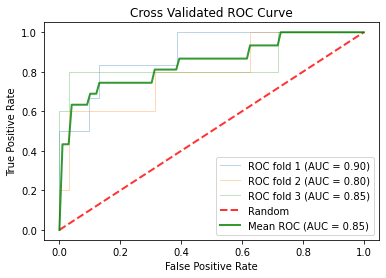

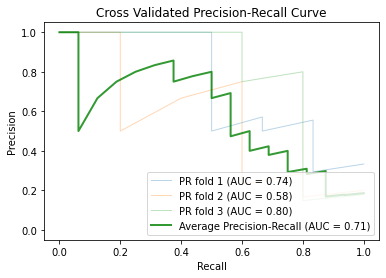

In [5]:
# assign the predictor and target variables
y = data.iloc[:, -1]
X = data.iloc[:, :-1]

# Normalize X
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
# Convert to a dataframe 
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# Make the stratified object
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

# get the ROC and PR curves
roc_curve_cv(best_rf, cv, X_scaled, y, title='Cross Validated ROC Curve')
pr_curve_cv(best_rf, cv, X_scaled, y, title='Cross Validated Precision-Recall Curve')
# get average performance metrics over multiple kfolds
model_metrics = metrics(best_rf, cv, X_scaled, y)

# output model metrics in csv to add to supplementary data

In [8]:
import csv

# Save to CSV
with open('rf_metrics.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Metric", "Value"])  # Header row
    for key, value in model_metrics.items():
        writer.writerow([key, value]) 


# Feature importance

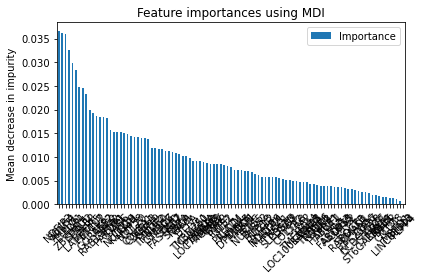

In [7]:
import pandas as pd

# Get feature importances from the best rf model
importance = best_rf.feature_importances_

# Get the feature names
feature_names = X.columns

# Create a DataFrame to display feature names with their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# Sort the features by importance in descending order
sorted_features = feature_importance_df.sort_values(by='Importance', ascending=False)

#plot the features of most importance
fig, ax = plt.subplots()
sorted_features.iloc[:101,:].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(sorted_features.iloc[:101, :]['Feature'], rotation=45)

fig.tight_layout()

In [12]:
#save important feature df in a csv file.
sorted_features.to_csv('rf_important_features.csv', index=False)